**Given the amount of milk productions (in thousand units per month) this month, what is the amount of milk productions (in thousand units per month) next month?**

Let us first import all the functions and classes we will use.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Let us fix the random number seed to ensure our results are reproducible.

In [3]:
# fix random seed for reproducibility
tf.random.set_seed(7)

Now, load the dataset 'monthly_milk_production.csv' as a Pandas data frame.

In [4]:
from google.colab import files

uploaded = files.upload()

Saving monthly_milk_production.csv to monthly_milk_production.csv


In [5]:
df = pd.read_csv('monthly_milk_production.csv',
                 index_col='Date',
                 parse_dates=True)

Let us check whether the dataset has been loaded properly or not by observing the first few rows of the dataset.

In [6]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


Let's visualize the data.

<Axes: xlabel='Date'>

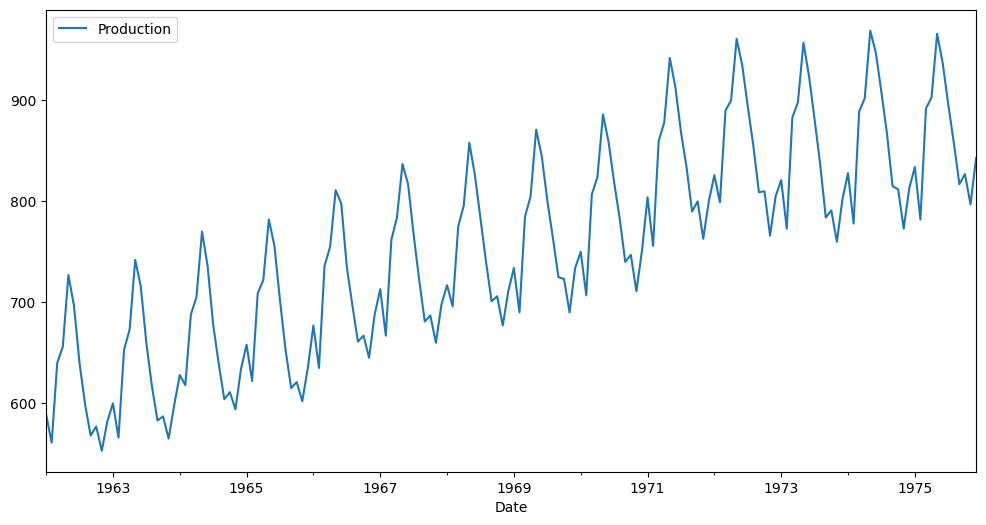

In [7]:
# Plotting graph b/w production and date
df.plot(figsize=(12, 6))

Let us do the seasonal analysis of time series data.

(<Figure size 640x480 with 4 Axes>, None)

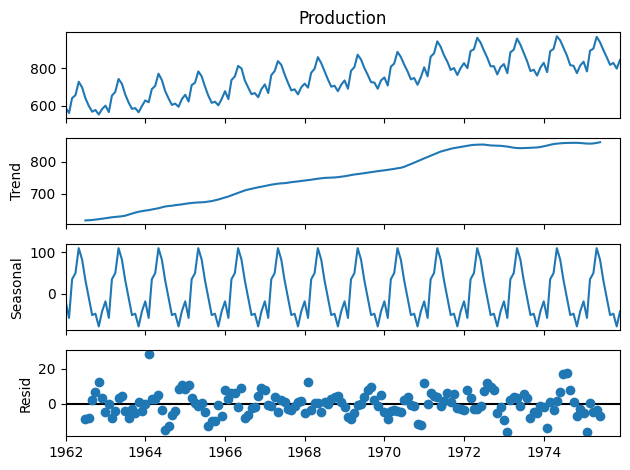

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['Production'])
results.plot(), plt.tight_layout()

We then extract the NumPy array from the data frame, followed by the conversion of the integer values to floating-point values, as these are more suitable for modeling with a neural network.

In [8]:
dataset = df.values
dataset = dataset.astype('float32')

As LSTMs are considered sensitive to the scale of the input data with activation functions like sigmoid (default) or tanh, it can be better to rescale the data to the range of 0-to-1, also known as normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class, which belongs to the scikit-learn library.

In [9]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In the case of time series data, there is a great importance of the sequence of values. Therefore, let us split the ordered dataset into train and test datasets by calculating the index of the split point and separating the data into the training datasets. Here, 67% of the observations are used to train the model, leaving the remaining 33% for testing the model.

In [10]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

112 56


Now, let us define a function for creating a new dataset, where the function takes two arguments: the dataset (for converting the NumPy array into a dataset) and the look_back (the number of previous time steps to use as input variables for predicting the next time period).

This default will create a dataset where X is the amount of milk productions at a given time (t), and Y is the amount of milk productions at the next time (t + 1).

In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)

Now we use this function for preparing the train and test datasets for modeling.

In [12]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

We have to provide the input data (X) in the form of [samples, time steps, features] to the LSTM network. The present form of the data is [samples, features]. Here, we have to add a one-time step for each sample as per the problem we are addressing with the help of numpy.reshape().

In [13]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Let us design the LSTM network in the following manner to fit with the given problem: a visible layer with 1 input, a hidden layer with 4 LSTM blocks, and an output layer that makes a single value prediction. The LSTM blocks have used the default sigmoid activation function. We train the network for 100 epochs, and here we use a batch size of 1.

In [15]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
model.summary()

Epoch 1/100
110/110 - 1s - loss: 0.1232 - 1s/epoch - 11ms/step
Epoch 2/100
110/110 - 0s - loss: 0.0618 - 129ms/epoch - 1ms/step
Epoch 3/100
110/110 - 0s - loss: 0.0342 - 136ms/epoch - 1ms/step
Epoch 4/100
110/110 - 0s - loss: 0.0265 - 123ms/epoch - 1ms/step
Epoch 5/100
110/110 - 0s - loss: 0.0245 - 127ms/epoch - 1ms/step
Epoch 6/100
110/110 - 0s - loss: 0.0231 - 131ms/epoch - 1ms/step
Epoch 7/100
110/110 - 0s - loss: 0.0217 - 129ms/epoch - 1ms/step
Epoch 8/100
110/110 - 0s - loss: 0.0200 - 125ms/epoch - 1ms/step
Epoch 9/100
110/110 - 0s - loss: 0.0183 - 129ms/epoch - 1ms/step
Epoch 10/100
110/110 - 0s - loss: 0.0168 - 133ms/epoch - 1ms/step
Epoch 11/100
110/110 - 0s - loss: 0.0150 - 128ms/epoch - 1ms/step
Epoch 12/100
110/110 - 0s - loss: 0.0138 - 133ms/epoch - 1ms/step
Epoch 13/100
110/110 - 0s - loss: 0.0128 - 126ms/epoch - 1ms/step
Epoch 14/100
110/110 - 0s - loss: 0.0119 - 124ms/epoch - 1ms/step
Epoch 15/100
110/110 - 0s - loss: 0.0115 - 129ms/epoch - 1ms/step
Epoch 16/100
110/110 

We observe that the model has an average error of about 43 units milk productions (in thousand units per month) on the training dataset and about 49 units milk productions (in thousand units per month) on the test dataset.

In [23]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 4ms/step
Train Score: 43.10 RMSE
Test Score: 49.35 RMSE


The current plot shows the original dataset in blue, the predictions for the training dataset in saffron, and the predictions for the unseen test dataset in green.

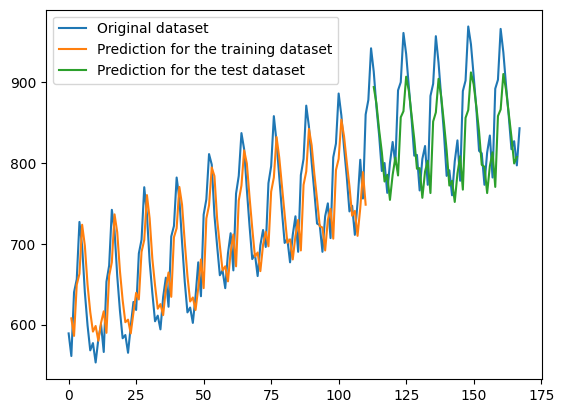

In [27]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(["Original dataset", "Prediction for the training dataset", "Prediction for the test dataset"], loc ="upper left")
plt.show()

We can observe that the model did an excellent job of fitting both the training and test datasets.